# Code for experiments with colored MNIST and Celeba


## 1. Imports


In [1]:
import logging
import os
import sys
from datetime import datetime

sys.path.append("..")

import gc
import json
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from IPython.display import clear_output

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
from tqdm import trange

%matplotlib inline


LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)
warnings.filterwarnings("ignore")

In [2]:
gc.collect()
torch.cuda.empty_cache()

## 2. Config

Dataset choosing in the first rows

Continue training in the last rows


In [3]:
# For Celeba exps
# DATASET1, DATASET1_PATH = "CelebA_low", "/home/zyz/data/img_align_celeba"
# DATASET2, DATASET2_PATH = "CelebA_high", "/home/zyz/data/img_align_celeba"

# For Colored MNIST exps
DATASET1, DATASET1_PATH = "MNIST-colored_2", "~/data/MNIST"
DATASET2, DATASET2_PATH = "MNIST-colored_3", "~/data/MNIST"

DATASET1_CHANNELS = 3
DATASET2_CHANNELS = 3

SEED = 0xBADBEEF

# GPU choosing
DEVICE_IDS = [0]

# whether continue training, -1 means re-training, N > -1 means continue at sdeN or iteration N
# In this training strategy, the "sde" doesn't matter
CONTINUE = {"sde": -1, "iteration": -1}


# We use epsilon in [0, 1, 10]
EPSILON = 0

# N steps in the Euler-Maruyama(step number of SDE shift and noise)
N_STEPS = 10
# COST = "schrodinger"


BATCH_SIZE = 64
# the step number adding noise in diffusion process style
DIFFUSION_STEPS = 1000
PIVOTAL_LIST = [0, 50, 100]

MAX_STEPS = 5001  # MAX_STEPS = 100001
INNER_ITERS = 10

LOG_INTERVAL = 50
PLOT_INTERVAL = 50
CPKT_INTERVAL = 200


# All hyperparameters below is set to the values used for the experiments, which discribed in the article
BETA_NET_LR, SDE_LR = 1e-4, 1e-4
BETA_NET_BETA, SDE_BETA = 0.9, 0.9
SDE_GRADIENT_MAX_NORM = float("inf")
BETA_NET_GRADIENT_MAX_NORM = float("inf")


IMG_SIZE = 32
UNET_BASE_FACTOR = 128

TIME_DIM = 128
USE_POSITIONAL_ENCODING = True
INTEGRAL_SCALE = 1 / (3 * IMG_SIZE * IMG_SIZE)

PREDICT_SHIFT = True
USE_GRADIENT_CHECKPOINT = False
N_LAST_STEPS_WITHOUT_NOISE = 1
EPSILON_SCHEDULER_LAST_ITER = 20000
IMAGE_INPUT = True

AUGMENTED_DATASETS = ["dtd"]
FID_EPOCHS = 50 if DATASET1 in AUGMENTED_DATASETS else 1
assert torch.cuda.is_available()
torch.cuda.set_device(f"cuda:{DEVICE_IDS[0]}")
torch.manual_seed(SEED)
np.random.seed(SEED)


In [4]:
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
EXP_NAME = f"Fix_{DATASET1}_to_{DATASET2}_pivotal_{'_'.join(map(str, PIVOTAL_LIST))}_{current_time}"

OUTPUT_PATH = f"../logs/{EXP_NAME}/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

# 配置日志
logging.basicConfig(
    level=logging.DEBUG,
    filename=os.path.join(OUTPUT_PATH, "training.log"),
    format="%(asctime)s - [line:%(lineno)d] - %(levelname)s: %(message)s",
    filemode="w",  # 这里的'w'代表写模式，如果用'a'，则为追加模式
)


logging.info(f"{EXP_NAME = }")
logging.info(f"{OUTPUT_PATH = }")

In [5]:
config = dict(
    DATASET1=DATASET1,
    DATASET1_PATH=DATASET1_PATH,
    DATASET2=DATASET2,
    DATASET2_PATH=DATASET2_PATH,
    DATASET1_CHANNELS=DATASET1_CHANNELS,
    DATASET2_CHANNELS=DATASET2_CHANNELS,
    SEED=SEED,
    EPSILON=EPSILON,
    N_STEPS=N_STEPS,
    BATCH_SIZE=BATCH_SIZE,
    DIFFUSION_STEPS=DIFFUSION_STEPS,
    PIVOTAL_LIST=PIVOTAL_LIST,
    MAX_STEPS=MAX_STEPS,
    INNER_ITERS=INNER_ITERS,
    LOG_INTERVAL=LOG_INTERVAL,
    PLOT_INTERVAL=PLOT_INTERVAL,
    CPKT_INTERVAL=CPKT_INTERVAL,
    BETA_NET_LR=BETA_NET_LR,
    SDE_LR=SDE_LR,
    BETA_NET_BETA=BETA_NET_BETA,
    SDE_BETA=SDE_BETA,
    SDE_GRADIENT_MAX_NORM=SDE_GRADIENT_MAX_NORM,
    BETA_NET_GRADIENT_MAX_NORM=BETA_NET_GRADIENT_MAX_NORM,
    IMG_SIZE=IMG_SIZE,
    UNET_BASE_FACTOR=UNET_BASE_FACTOR,
    TIME_DIM=TIME_DIM,
    USE_POSITIONAL_ENCODING=USE_POSITIONAL_ENCODING,
    INTEGRAL_SCALE=INTEGRAL_SCALE,
    PREDICT_SHIFT=PREDICT_SHIFT,
    USE_GRADIENT_CHECKPOINT=USE_GRADIENT_CHECKPOINT,
    N_LAST_STEPS_WITHOUT_NOISE=N_LAST_STEPS_WITHOUT_NOISE,
    EPSILON_SCHEDULER_LAST_ITER=EPSILON_SCHEDULER_LAST_ITER,
    IMAGE_INPUT=IMAGE_INPUT,
    FID_EPOCHS=FID_EPOCHS,
)

with open(os.path.join(OUTPUT_PATH, "config.json"), "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False)
logging.info(f"Config: \n{json.dumps(config, indent=4)}")


## 3. Function definition


### network generator


In [6]:
from src.cunet import CUNet
from src.enot import SDE, integrate
from src.resnet2 import ResNet_D

### data and pivotal sampler


In [7]:
from diffusers import DDIMScheduler

from src import distributions


def sample_all_pivotal(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    batch_size: int = 4,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 20, 50, 100],
) -> list[torch.Tensor]:
    scheduler = DDIMScheduler(num_train_timesteps=diffusion_steps)
    pivotal_path = []

    source: torch.Tensor = source_sampler.sample(batch_size)
    target: torch.Tensor = target_sampler.sample(batch_size)
    source_list = [source]
    target_list = [target]
    for i in range(min(diffusion_steps, pivotal_list[-1])):
        source = scheduler.add_noise(
            source, torch.randn_like(source), torch.Tensor([i]).long()
        )
        target = scheduler.add_noise(
            target, torch.randn_like(target), torch.Tensor([i]).long()
        )
        if (i + 1) in pivotal_list:
            source_list.append(source)
            target_list.append(target)

    target_list.reverse()

    pivotal_path.extend(source_list)
    pivotal_path.extend(target_list[1:])

    return pivotal_path


def sample_step_t_pivotal(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    batch_size: int = 4,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 200, 500, 1000],
    pivotal_step: int = 0,
):
    pivotal_path = sample_all_pivotal(
        source_sampler, target_sampler, batch_size, diffusion_steps, pivotal_list
    )
    pivotal_t, pivotal_tadd1 = (
        pivotal_path[pivotal_step],
        pivotal_path[pivotal_step + 1],
    )
    return pivotal_t, pivotal_tadd1

### mapping plotters


In [8]:
# 采样关键点
def draw_all_pivotal(
    source: torch.Tensor,
    target: torch.Tensor,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 20, 50, 100],
) -> list:
    scheduler = DDIMScheduler(num_train_timesteps=diffusion_steps)
    pivotal_path = []

    source_list = [source]
    target_list = [target]
    for i in range(min(diffusion_steps, pivotal_list[-1])):
        source = scheduler.add_noise(
            source, torch.randn_like(source), torch.Tensor([i]).long()
        )
        target = scheduler.add_noise(
            target, torch.randn_like(target), torch.Tensor([i]).long()
        )
        if (i + 1) in pivotal_list:
            source_list.append(source)
            target_list.append(target)

    target_list.reverse()

    pivotal_path.extend(source_list)
    pivotal_path.extend(target_list[1:])

    imgs: np.ndarray = (
        torch.stack(pivotal_path)
        .to("cpu")
        .permute(0, 2, 3, 1)
        .mul(0.5)
        .add(0.5)
        .numpy()
        .clip(0, 1)
    )
    nrows, ncols = 1, len(pivotal_path)
    fig = plt.figure(figsize=(11 * ncols, 10 * nrows))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        ax.imshow(img)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(f"X({i})")

    torch.cuda.empty_cache()
    gc.collect()


@torch.no_grad()
def draw_sub_mapping(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    sde: SDE,
    plot_n_samples: int = 4,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 200, 500, 1000],
    pivotal_step: int = 0,
    saving_path: str | None = None,
):
    clear_output()
    source, target = sample_step_t_pivotal(
        source_sampler,
        target_sampler,
        plot_n_samples,
        diffusion_steps,
        pivotal_list,
        pivotal_step,
    )

    tr, _, _ = sde(source)
    # print(f"[Debug] {tr.shape = }")
    mapped = tr[:, -1, :]
    # print(f"[Debug] {mapped.shape = }") # shape (plot_n_sample, 3, 32, 32)

    n_imgs: np.ndarray = (
        torch.stack([source, target, mapped])
        .to("cpu")
        .permute(1, 0, 3, 4, 2)
        .mul(0.5)
        .add(0.5)
        .numpy()
        .clip(0, 1)
    )  # shpae = (plot_n_samples, 3, [h, w, c]) 3->(source, target, mapped)
    nrows, ncols = plot_n_samples, 3
    fig = plt.figure(figsize=(10 * ncols, 10 * nrows))
    for i, imgs in enumerate(n_imgs):
        for j, img in enumerate(imgs):
            ax = fig.add_subplot(plot_n_samples, 3, i * ncols + j + 1)
            ax.imshow(img)
            ax.set_axis_off()

    fig.tight_layout()

    if saving_path:
        plt.savefig(os.path(saving_path))
    plt.show()

    torch.cuda.empty_cache()
    gc.collect()


@torch.no_grad()
def draw_linked_mapping(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    SDEs: list[SDE],
    plot_n_samples: int = 4,
):
    device = next(SDEs[0].parameters()).device
    source_dataset, target_dataset, mapped_dataset = [], [], []
    pivotals_list = []
    for i in range(plot_n_samples):
        source, target = (
            source_sampler.sample(1).to(device),
            target_sampler.sample(1).to(device),
        )

        pivotals = [source.clone().detach()]
        for t in range(len(SDEs)):
            x0 = pivotals[t]
            trajectory, times, _ = SDEs[t](x0)
            xN = trajectory[:, -1, :]
            pivotals.append(xN)

        mapped_dataset.append(pivotals[-1])
        source_dataset.append(source)
        target_dataset.append(target)

        pivotals.append(target.clone().detach())
        pivotals_list.append(pivotals)

        fig, axes = plt.subplots(1, len(SDEs) + 2, figsize=(5 * (len(SDEs) + 2), 5))
        axes = axes.flatten()
        for pivotal, ax in zip(pivotals, axes):
            img = torch.squeeze(pivotal).to("cpu")
            img = img.permute(1, 2, 0).mul(0.5).add(0.5).numpy().clip(0, 1)
            ax.imshow(img)

        fig.tight_layout(pad=0.001)

    plt.show()

    torch.cuda.empty_cache()
    gc.collect()

    return pivotals_list

### trainer


In [9]:
from src.tools import freeze, unfreeze, weights_init_D


def epsilon_scheduler(step):
    return min(EPSILON, EPSILON * (step / EPSILON_SCHEDULER_LAST_ITER))


# linked mapping training
def training_linked_mapping(
    source_sampler: distributions.Sampler,
    target_sampler: distributions.Sampler,
    SDEs: list[SDE | torch.nn.DataParallel | torch.nn.Module],
    BETA_NETs: list[ResNet_D | torch.nn.Module | torch.nn.Module],
    SDE_OPTs: list[torch.optim.Optimizer],
    BETA_NET_OPTs: list[torch.optim.Optimizer],
    SDE_SCHEDULERs: list[torch.optim.lr_scheduler.LRScheduler],
    BETA_NET_SCHEDULERs: list[torch.optim.lr_scheduler.LRScheduler],
    iterations: int = 1000,
    inner_iterations: int = 10,
    diffusion_steps: int = 1000,
    pivotal_list: list[int] = [0, 200, 500, 1000],
    batch_size: int = BATCH_SIZE,
):
    T = len(SDEs)
    for i in trange(iterations):
        # interval events
        if i % LOG_INTERVAL == 0:
            logging.info(f"-------------- Iteration={i+1}/{iterations} --------------")

        if i != 0 and i % CPKT_INTERVAL == 0:
            CKPT_DIR = os.path.join(OUTPUT_PATH, f"iter{i}/")
            os.makedirs(CKPT_DIR, exist_ok=True)
            for tt in range(T):
                torch.save(
                    SDEs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"sde{tt}.pt"),
                )
                torch.save(
                    SDE_OPTs[tt].state_dict(), os.path.join(CKPT_DIR, f"sde_opt{tt}.pt")
                )
                torch.save(
                    SDE_SCHEDULERs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"sde_scheduler{tt}.pt"),
                )

                torch.save(
                    BETA_NETs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"beta_net{tt}.pt"),
                )
                torch.save(
                    BETA_NET_OPTs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"beta_net_opt{tt}.pt"),
                )
                torch.save(
                    BETA_NET_SCHEDULERs[tt].state_dict(),
                    os.path.join(CKPT_DIR, f"beta_net_scheduler{tt}.pt"),
                )
                logging.info(f"Checkpoint saving at iteration {i}")

        if i % PLOT_INTERVAL == 0:
            clear_output()
            draw_linked_mapping(
                source_sampler,
                target_sampler,
                SDEs,
                1,
            )

        # sample fixed training data for all sdes
        mapping_list_list: list[list[torch.Tensor]] = []
        for _ in range(inner_iterations):
            mapping_list = sample_all_pivotal(
                source_sampler,
                target_sampler,
                batch_size,
                diffusion_steps,
                pivotal_list,
            )
            mapping_list_list.append(mapping_list)

        # training sde
        for t in range(T):
            logging.info(f"training sde{t}")
            sde, beta_net, sde_opt, beta_net_opt, sde_scheduler, beta_net_scheduler = (
                SDEs[t],
                BETA_NETs[t],
                SDE_OPTs[t],
                BETA_NET_OPTs[t],
                SDE_SCHEDULERs[t],
                BETA_NET_SCHEDULERs[t],
            )

            # Sub mapping training
            # Optim beta network
            freeze(sde)
            unfreeze(beta_net)
            beta_net.train()

            # clear grad
            beta_net_opt.zero_grad()

            x0, xT = mapping_list_list[0][t], mapping_list_list[0][t + 1]
            x0, xT = x0.clone().detach(), xT.clone().detach()
            x0.requires_grad_()
            xT.requires_grad_()

            # forward
            trajectory, times, shifts = sde(x0)
            xT_mapped = trajectory[:, -1, :]
            # loss
            norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1) ** 2
            integral = INTEGRAL_SCALE * integrate(norm, times[0])
            loss_beta = (-integral - beta_net(xT) + beta_net(xT_mapped)).mean()
            # backward
            loss_beta.backward()
            # clip gradient
            beta_net_grad_norm = torch.nn.utils.clip_grad_norm_(  # noqa: F841
                beta_net.parameters(), max_norm=BETA_NET_GRADIENT_MAX_NORM
            )
            # update weights
            beta_net_opt.step()
            # update beta network lr scheduler
            beta_net_scheduler.step()

            # Optim sde network
            freeze(beta_net)
            unfreeze(sde)
            sde.train()

            new_epsilon = epsilon_scheduler(i)
            if len(DEVICE_IDS) > 1:
                sde.module.set_epsilon(new_epsilon)
            else:
                sde.set_epsilon(new_epsilon)

            # now it's same sample
            for ii in range(inner_iterations):
                # clear grad
                sde_opt.zero_grad()

                x0, xT = mapping_list_list[ii][t], mapping_list_list[ii][t + 1]
                x0, xT = x0.clone().detach(), xT.clone().detach()
                x0.requires_grad_()
                xT.requires_grad_()

                # forward
                trajectory, times, shifts = sde(x0)
                xT_mapped = trajectory[:, -1, :]
                # loss
                norm = torch.norm(shifts.flatten(start_dim=2), p=2, dim=-1) ** 2
                integral = INTEGRAL_SCALE * integrate(norm, times[0])
                loss_sde = (integral + beta_net(xT) - beta_net(xT_mapped)).mean()
                # backward and update weights
                loss_sde.backward()
                # clip gradient
                sde_gradient_norm = torch.nn.utils.clip_grad_norm_(  # noqa: F841
                    sde.parameters(), max_norm=SDE_GRADIENT_MAX_NORM
                )
                # update weights
                sde_opt.step()
            # update sde network lr scheduler
            sde_scheduler.step()
        # clear memory cache
        del loss_beta, loss_sde, x0, xT, xT_mapped
        gc.collect()
        torch.cuda.empty_cache()

## 4. Train


### initalize data sampler


In [10]:
from src.tools import load_dataset

X_sampler, X_test_sampler = load_dataset(
    DATASET1, DATASET1_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8
)
Y_sampler, Y_test_sampler = load_dataset(
    DATASET2, DATASET2_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE, num_workers=8
)

torch.cuda.empty_cache()
gc.collect()
clear_output()

logging.info("Initialize data sampler")

### separate fixed X, Y, show sampler data and pivotal


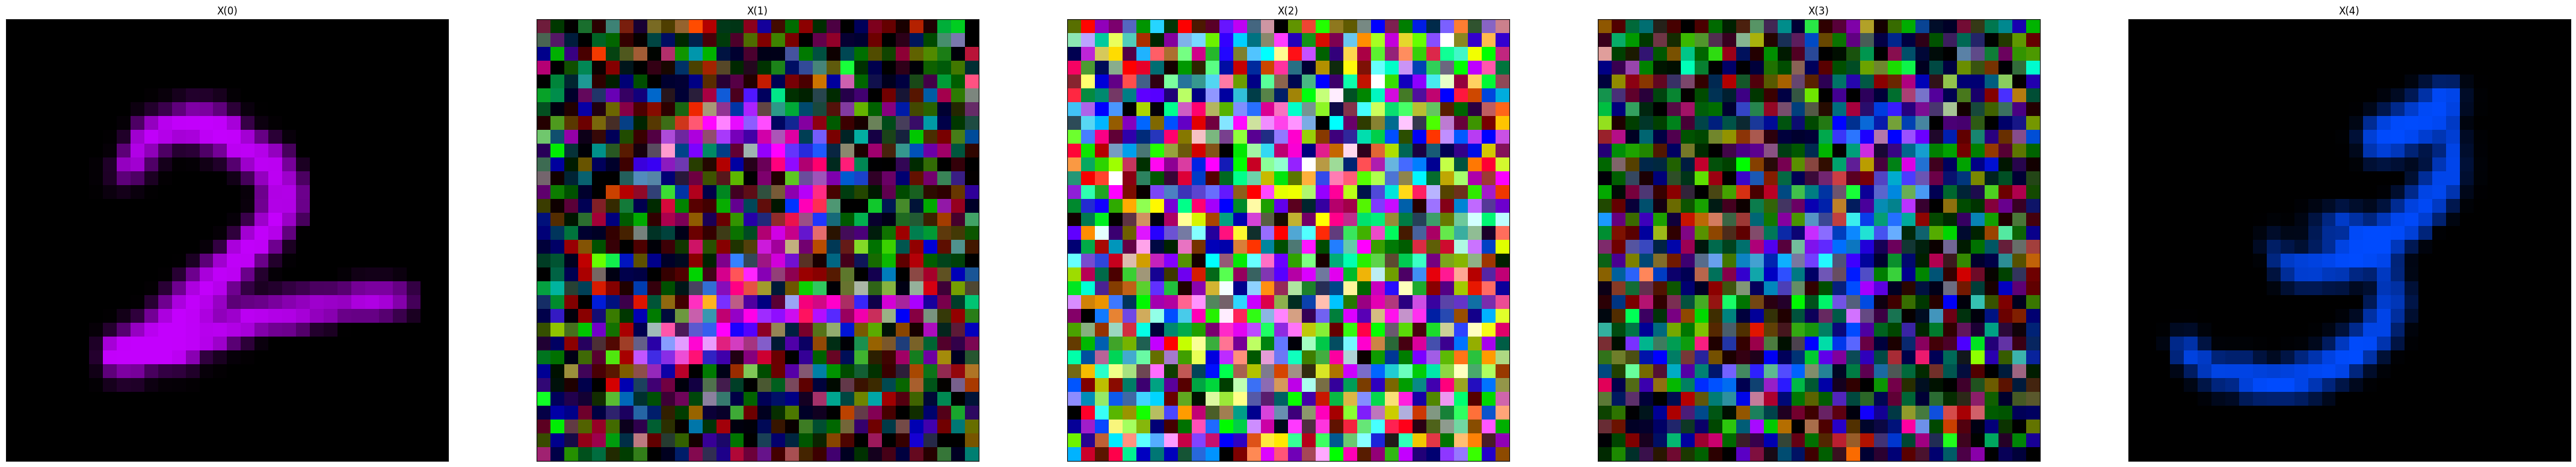

In [11]:
X_fixed, Y_fixed = X_sampler.sample(10), Y_sampler.sample(10)

X_test_fixed, Y_test_fixed = X_test_sampler.sample(10), Y_test_sampler.sample(10)

draw_all_pivotal(X_fixed[0], Y_fixed[0], DIFFUSION_STEPS, PIVOTAL_LIST)

### initialize model


In [12]:
SDEs, BETA_NETs = [], []
SDE_OPTs, BETA_NET_OPTs = [], []
SDE_SCHEDULERs, BETA_NET_SCHEDULERs = [], []

for i in range(len(PIVOTAL_LIST) * 2 - 2):
    sde = CUNet(
        DATASET1_CHANNELS, DATASET2_CHANNELS, TIME_DIM, base_factor=UNET_BASE_FACTOR
    ).cuda()

    sde = SDE(
        shift_model=sde,
        epsilon=EPSILON,
        n_steps=N_STEPS,
        time_dim=TIME_DIM,
        n_last_steps_without_noise=N_LAST_STEPS_WITHOUT_NOISE,
        use_positional_encoding=USE_POSITIONAL_ENCODING,
        use_gradient_checkpoint=USE_GRADIENT_CHECKPOINT,
        predict_shift=PREDICT_SHIFT,
        image_input=IMAGE_INPUT,
    ).cuda()
    SDEs.append(sde)

    beta_net = ResNet_D(IMG_SIZE, nc=DATASET2_CHANNELS).cuda()
    beta_net.apply(weights_init_D)
    BETA_NETs.append(beta_net)

    sde_opt = torch.optim.Adam(
        sde.parameters(), lr=SDE_LR, weight_decay=1e-10, betas=(SDE_BETA, 0.999)
    )
    beta_net_opt = torch.optim.Adam(
        beta_net.parameters(),
        lr=BETA_NET_LR,
        weight_decay=1e-10,
        betas=(BETA_NET_BETA, 0.999),
    )
    SDE_OPTs.append(sde_opt)
    BETA_NET_OPTs.append(beta_net_opt)

    sde_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        sde_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5
    )
    beta_net_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        beta_net_opt, milestones=[15000, 25000, 40000, 55000, 70000], gamma=0.5
    )
    SDE_SCHEDULERs.append(sde_scheduler)
    BETA_NET_SCHEDULERs.append(beta_net_scheduler)


if len(DEVICE_IDS) > 1 and CONTINUE[0] == -1 and CONTINUE[1] == -1:
    for i in range(len(SDEs)):
        SDEs[i] = nn.DataParallel(SDEs[i], device_ids=DEVICE_IDS)
        BETA_NETs[i] = nn.DataParallel(BETA_NETs[i], device_ids=DEVICE_IDS)

        print("T params:", np.sum([np.prod(p.shape) for p in SDEs[0].parameters()]))
        print(
            "D params:", np.sum([np.prod(p.shape) for p in BETA_NETs[0].parameters()])
        )

logging.info("Initialize models")

#### Load weights for continue training


In [13]:
CKPT_DIR = os.path.join(OUTPUT_PATH, f"iter{CONTINUE["iteration"]}/")
if CONTINUE["iteration"] > -1:
    for i in range(len(SDEs)):
        SDEs[i].load_state_dict(torch.load(os.path.join(CKPT_DIR, f"sde{i}.pt")))
        SDE_OPTs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"sde_opt{i}.pt"))
        )
        SDE_SCHEDULERs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"sde_scheduler{i}.pt"))
        )

        BETA_NETs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"beta_net{i}.pt"))
        )
        BETA_NET_OPTs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"beta_net_opt{i}.pt"))
        )
        BETA_NET_SCHEDULERs[i].load_state_dict(
            torch.load(os.path.join(CKPT_DIR, f"beta_net_scheduler{i}.pt"))
        )

        if len(DEVICE_IDS) > 1:
            SDEs[i] = nn.DataParallel(sde, device_ids=DEVICE_IDS)
            BETA_NETs[i] = nn.DataParallel(beta_net, device_ids=DEVICE_IDS)

    logging.info(f"Continue training at iteration {CONTINUE["iteration"]}")


### training


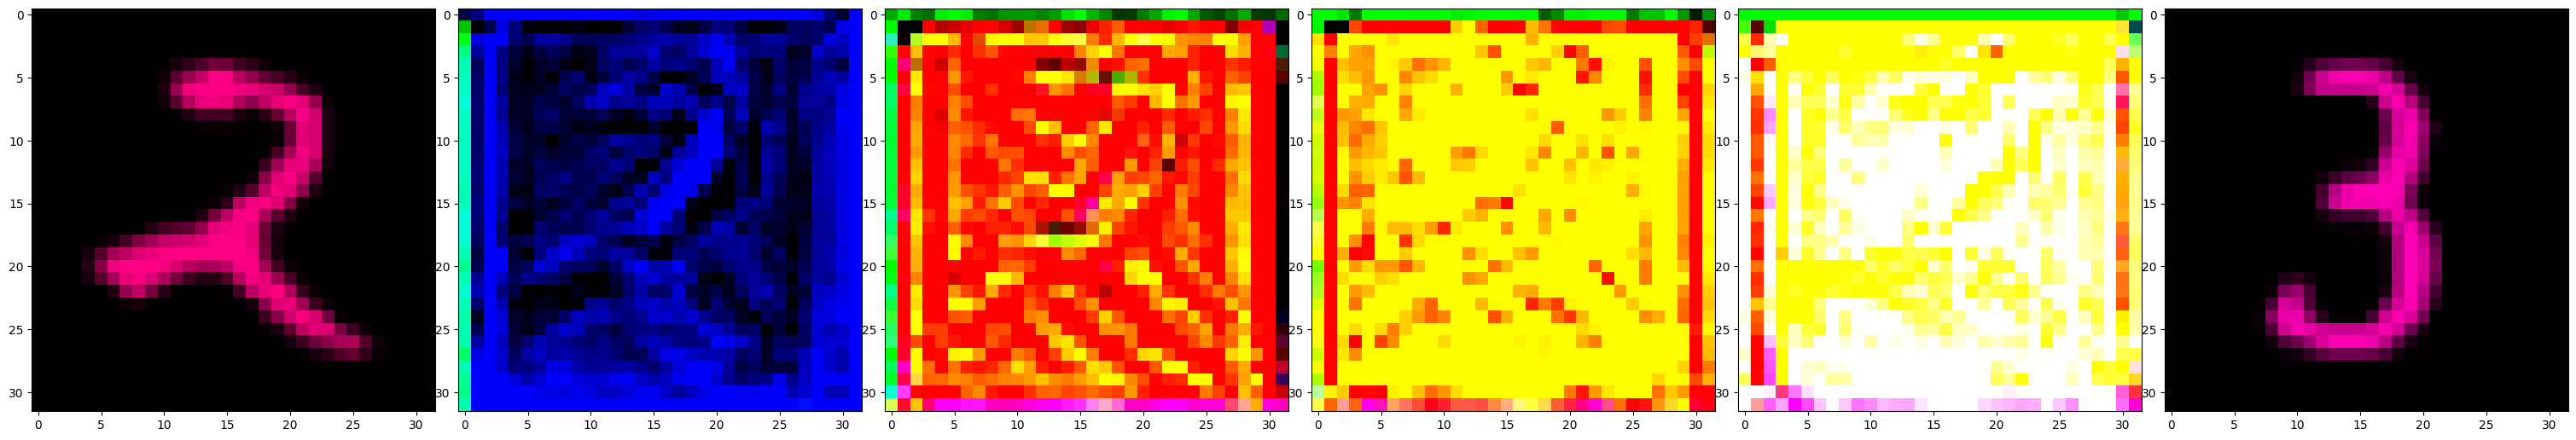

  0%|                                                                                                                                                                                                | 2/5001 [00:43<30:05:06, 21.67s/it]

In [ ]:
training_linked_mapping(
    X_sampler,
    Y_sampler,
    SDEs,
    BETA_NETs,
    SDE_OPTs,
    BETA_NET_OPTs,
    SDE_SCHEDULERs,
    BETA_NET_SCHEDULERs,
    MAX_STEPS,
    INNER_ITERS,
    DIFFUSION_STEPS,
    PIVOTAL_LIST,
    BATCH_SIZE,
)

### saving model

each sub mapping model has been saved at training time, this is option code


In [ ]:
for i, sde in enumerate(SDEs):
    path = os.path.join(OUTPUT_PATH, f"sde{i}.pt")
    torch.save(sde.state_dict(), path)

## 5. Metric

total test in the ../test/test_diffot_image.ipynb


In [ ]:
CKPT_DIR = os.path.join(OUTPUT_PATH, "iter2000/")
for i, sde in enumerate(SDEs):
    path = os.path.join(CKPT_DIR, f"sde{i}.pt")
    print(f"{path = }")
    sde.load_state_dict(torch.load(path))

### trans example


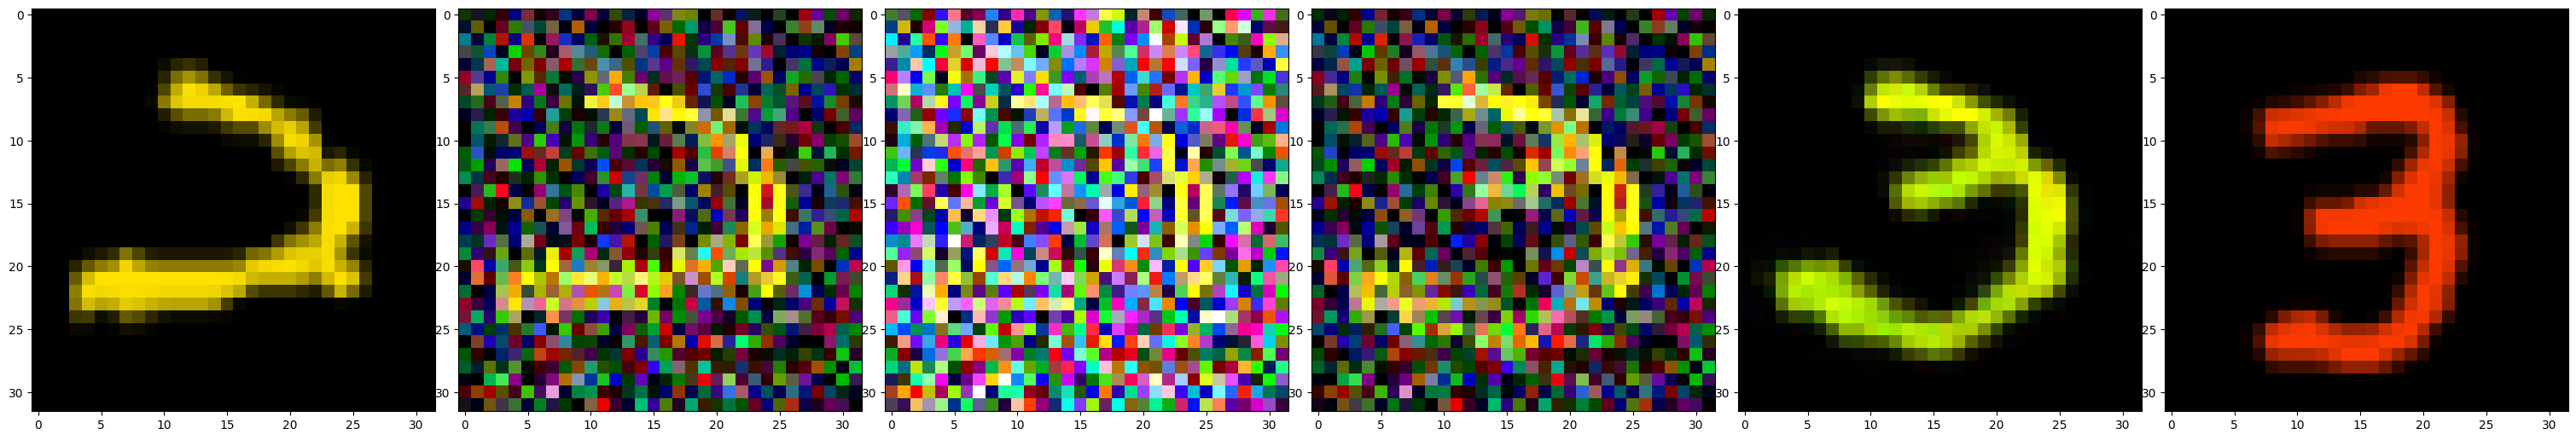

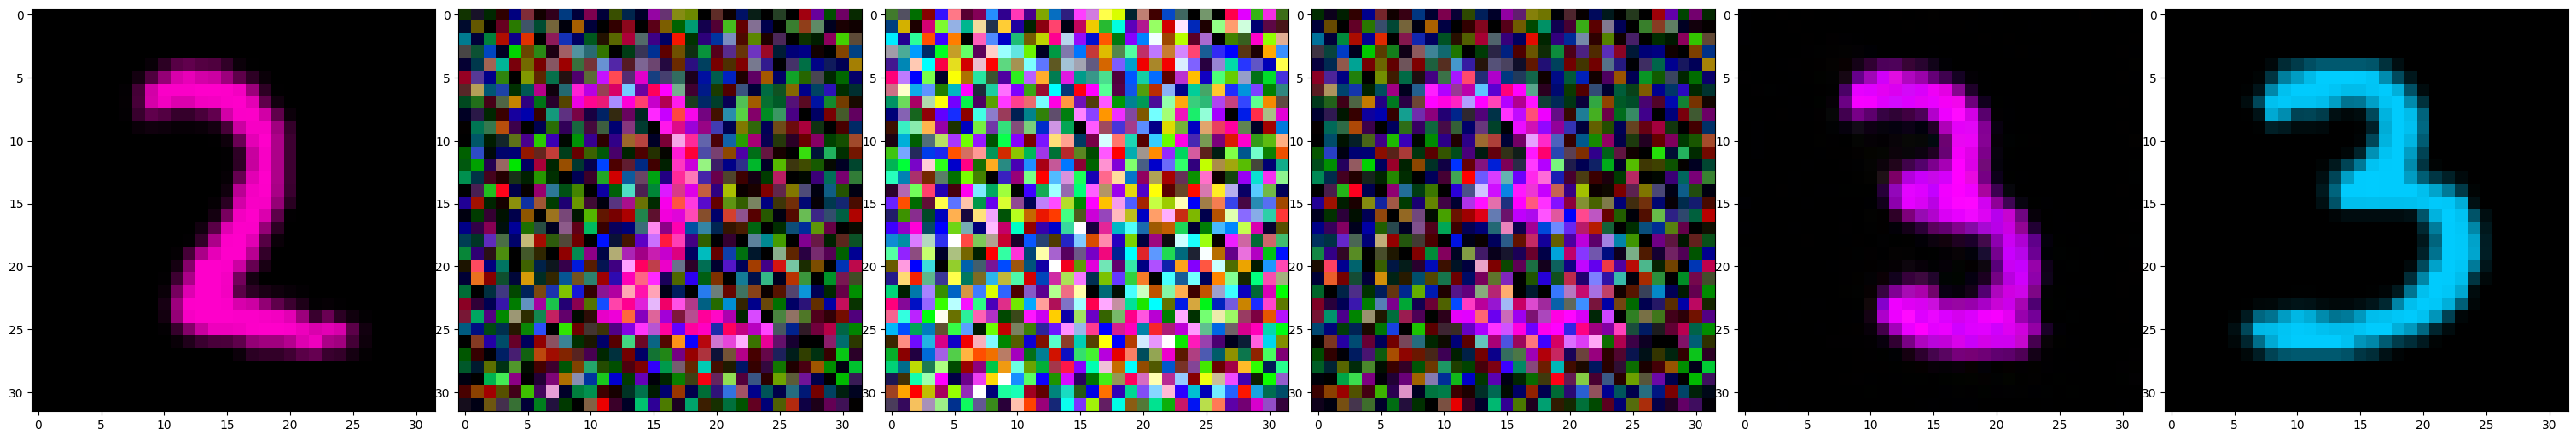

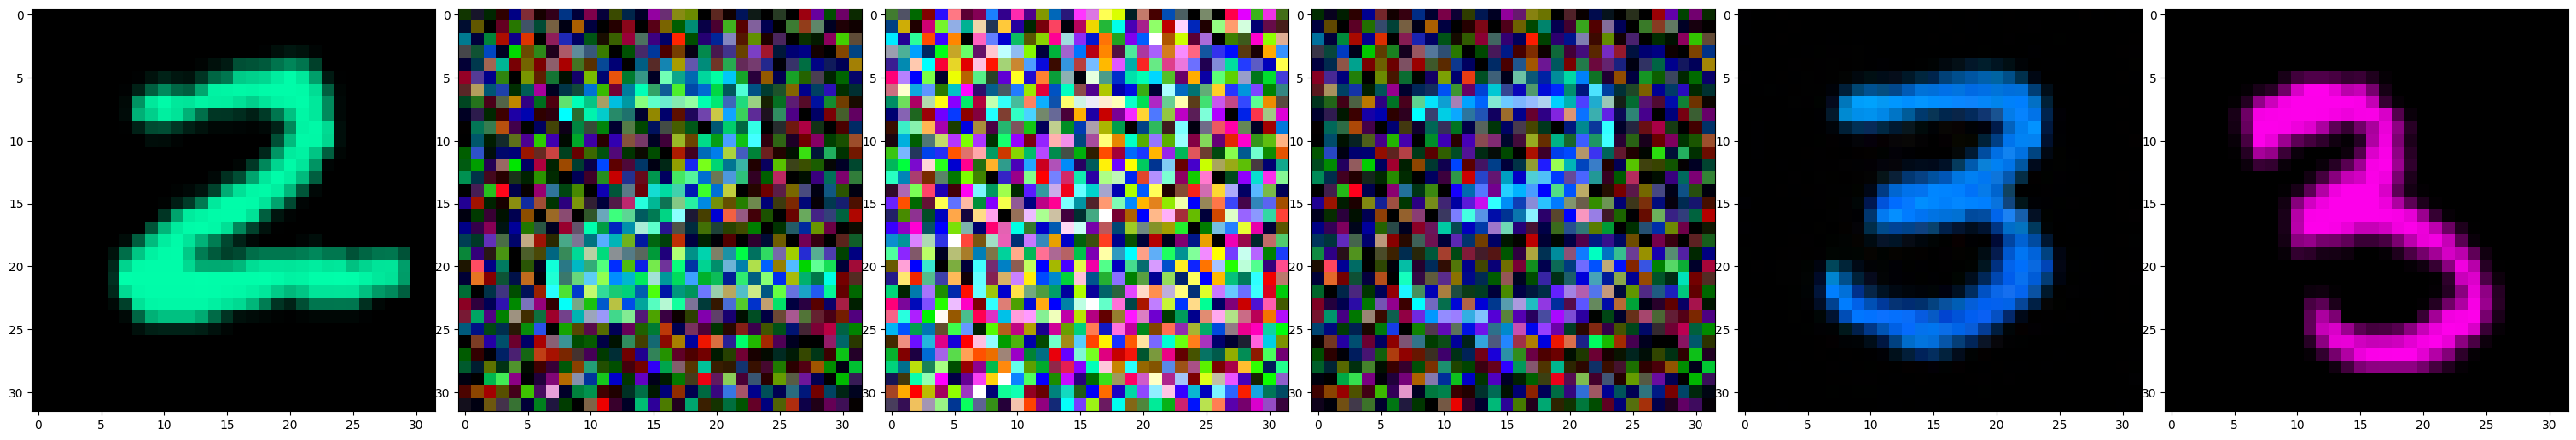

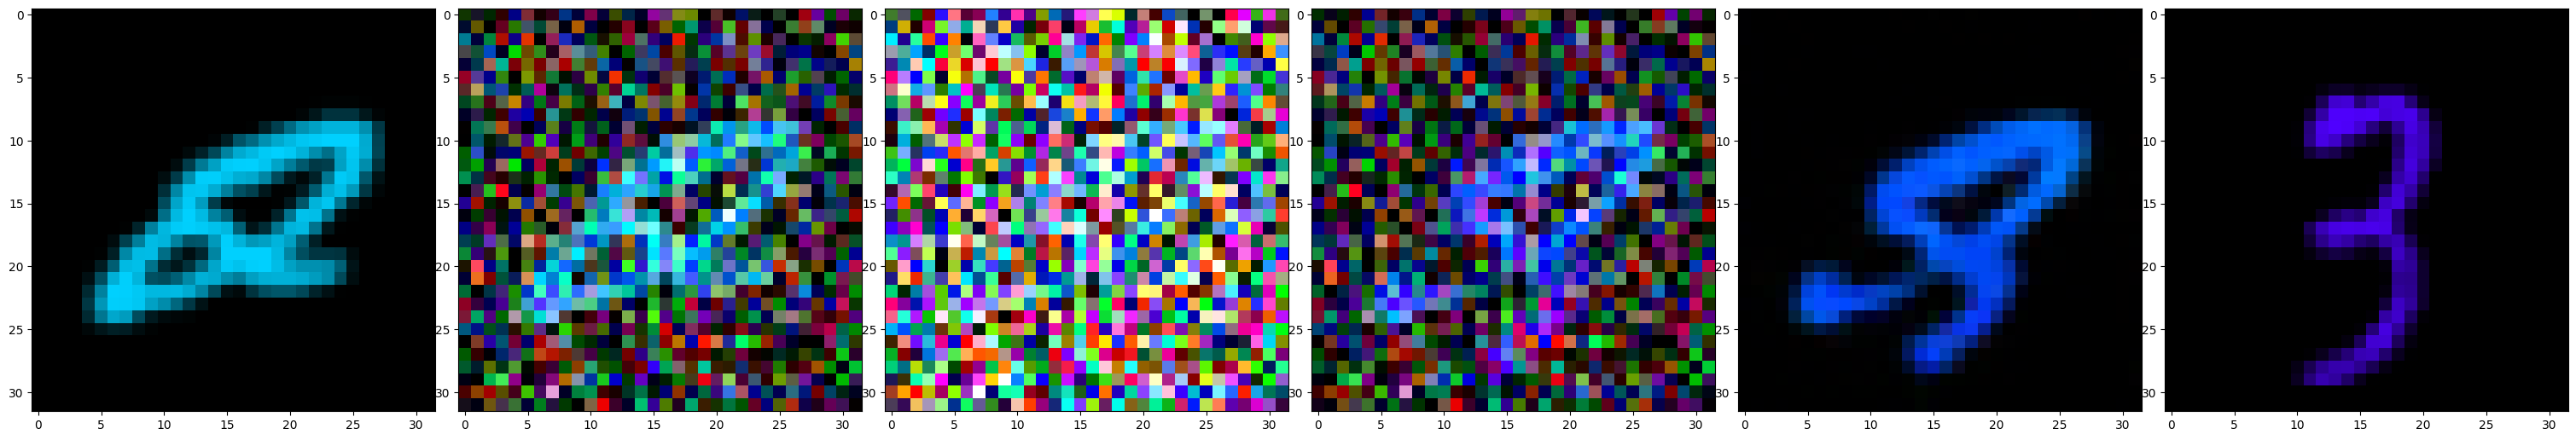

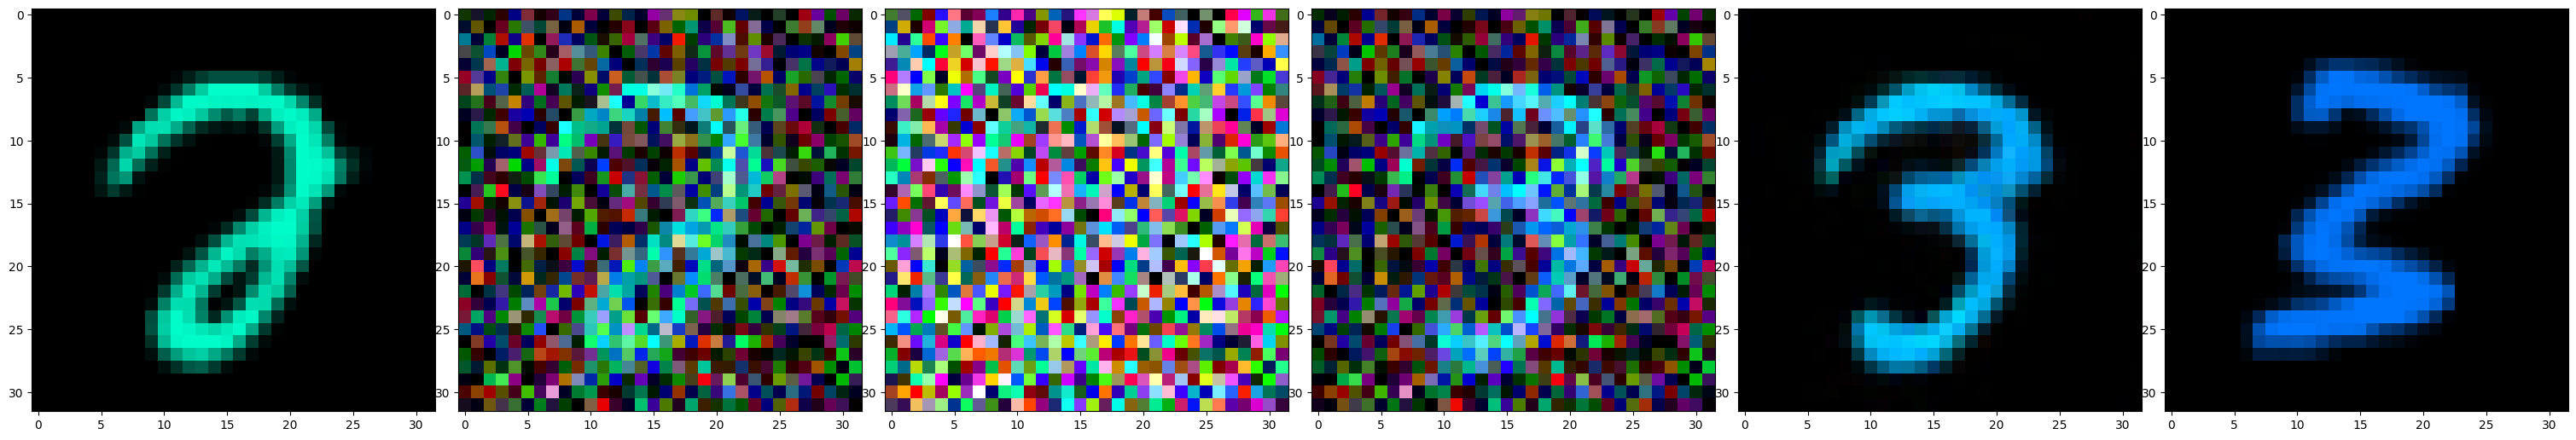

In [16]:
# pivotals_list shape (plot_n_samples, n_steps, (RGB image))
pivotals_list = draw_linked_mapping(
    X_sampler,
    Y_sampler,
    SDEs,
    plot_n_samples=5,
)

In [ ]:
for pivotals in pivotals_list:
    fig, axes = plt.subplots(1, 8, figsize=(40, 5))
    axes = axes.flatten()
    for pivotal, ax in zip(pivotals, axes):
        img = torch.squeeze(pivotal).to("cpu")
        img = img.permute(1, 2, 0).mul(0.5).add(0.5).numpy().clip(0, 1)
        ax.imshow(img)